In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
train = pd.read_csv('data/ner_dataset.csv')
train['Word'] = train['Word'].map(str.lower)
train.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [8]:
with open('data/penn_trebank.txt', 'tr') as f:
    content = f.readlines()

tidy = {}
for i in range(0, len(content)-1, 2):
    tidy[content[i].strip()] = content[i+1].strip()

In [9]:
tags_for_removal = set(train['POS'].values)- set(tidy.keys())
print(f'tags in training, but not in the original treebank set: {tags_for_removal}')

tags in training, but not in the original treebank set: {'LRB', ',', '$', '.', 'RRB', '``', ':', ';'}


In [10]:
# Decide on the features to determine the window size for training
input_data = []
for tup in train[['Word', 'POS', 'Tag']].itertuples(index = False, name=None):
    if tup[1] not in tags_for_removal:
        input_data.append(tup)
input_data[:20]

[('thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('london', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('british', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O')]

In [11]:
sequence_length = 3

matrix = []
for index in range(len(input_data)):
    if index+sequence_length>len(input_data):
        break
    matrix.append(input_data[index:index+sequence_length])
    index+=sequence_length

In [12]:
matrix[:5]

[[('thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O')],
 [('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O')],
 [('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O')],
 [('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O')],
 [('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('london', 'NNP', 'B-geo')]]

In [13]:
suffixes = []
for item in set(train['Word']):
    suffixes.append(item[-3:])
        
pos_vocab = set(train['POS'])
index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = {v:k for k, v in index_to_pos.items()}

tag_vocab = set(train['Tag'])
index_to_tag = {k:v for k, v in enumerate(tag_vocab)}
tag_to_index = {v:k for k, v in index_to_tag.items()}

word_vocab = set(train['Word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = {v:k for k, v in index_to_word.items()}

print(len(word_vocab), len(pos_vocab), len(tag_vocab))

31811
34764
34764 42 17


In [65]:
def build_features(row):
    features = []
    
    features.append(word_to_index[row[1][0].lower()])
    features.append(word_to_index[row[1][0][-3:]])
#    features.append(row[1][0][-2:])
    features.append(int(row[1][0].istitle()))
    features.append(int(row[1][0].isupper()))    
    features.append(int(row[1][0].isdigit()))    
    features.append(pos_to_index[row[1][1]])
#    features.append(row[1][1][:2])    
    
    
    features.append(word_to_index[row[0][0].lower()])
    features.append(int(row[0][0].istitle()))
    features.append(int(row[0][0].isupper()))   
    features.append(pos_to_index[row[0][1]])
#    features.append(row[0][1][:2])    

    features.append(word_to_index[row[2][0].lower()])
    features.append(int(row[2][0].istitle()))
    features.append(int(row[2][0].isupper()))
    features.append(pos_to_index[row[2][1]])
#    features.append(row[2][1][:2])    

    features.append(tag_to_index[row[1][2]])
    return features
    
feature_extractor(matrix[0])

[11313, 11313, 0, 0, 0, 10, 27804, 0, 0, 29, 28401, 0, 0, 29, 0]

In [66]:
transformed_matrix = []

for row in matrix:
    features = build_features(row)    
    transformed_matrix.append(features)  

In [69]:
len(transformed_matrix[0])

15

In [70]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=14))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(tag_vocab), activation='sigmoid'))

    return model

In [73]:
model = get_model(len(word_vocab)+len(pos_vocab)+len(tag_vocab), 100)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 100)           3482300   
_________________________________________________________________
flatten (Flatten)            (None, 1400)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1717      
Total params: 3,624,117
Trainable params: 3,624,117
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalAccuracy()])

In [75]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(tag_vocab))
X.shape, y.shape

((960742, 14), (960742, 17))

In [78]:
max_train_size = 10000
X_train = X[:max_train_size]
X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

y_train = y[:max_train_size]
y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

Epoch 1/10
313/313 [==============================] - 9s 27ms/step - loss: 0.2881 - categorical_accuracy: 0.9211 - val_loss: 0.1562 - val_categorical_accuracy: 0.9580
Epoch 2/10
313/313 [==============================] - 9s 27ms/step - loss: 0.1301 - categorical_accuracy: 0.9668 - val_loss: 0.1174 - val_categorical_accuracy: 0.9670
Epoch 3/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0686 - categorical_accuracy: 0.9821 - val_loss: 0.1157 - val_categorical_accuracy: 0.9700
Epoch 4/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0374 - categorical_accuracy: 0.9902 - val_loss: 0.1308 - val_categorical_accuracy: 0.9660
Epoch 5/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0213 - categorical_accuracy: 0.9947 - val_loss: 0.1478 - val_categorical_accuracy: 0.9640


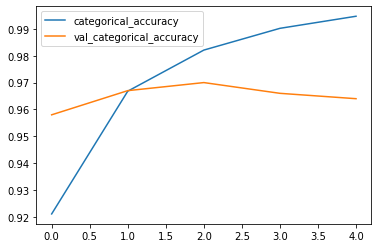

In [79]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2))

for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [80]:
model.save('data/ner_model/')

INFO:tensorflow:Assets written to: data/ner_model/assets


In [81]:
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.9801980198019802
0.9751243781094527
0.9767441860465116
0.9775561097256857
0.9700598802395209
0.9667221297836939
0.9657631954350927
0.9675405742821473
0.9633740288568258


In [85]:
it = train[['Word', 'POS', 'Tag']].itertuples(index=False, name=None)
row = []
for a in range (5):
    row.append(next(it))

In [86]:
row

[('thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O')]

In [87]:
features = build_features(row)[:-1]
features

[11313, 11313, 0, 0, 0, 10, 27804, 0, 0, 29, 28401, 0, 0, 29]

In [89]:
prediction = model.predict(np.array(features).reshape(1,-1))
np.argmax(prediction)

0

In [90]:
index_to_tag[0]

'O'

In [2]:
model = keras.models.load_model('data/ner_model/')